# 6章 学習に関するテクニック

本章で取り上げること：
* 最適な重みパラメータを探索するための最適化手法
* 重みパラメータの初期値
* ハイパーパラメータの設定方法
* 過学習の対応策としての正規化手法
  * Weight decay
  * Dropout
  * Batch Normalization

## 6.1 パラメータの更新

* ニューラルネットワークの学習は最適化(optimization)問題
  * 損失関数の値をできるだけ小さくするパラメータを見つける
  * パラメータ空間は非常に複雑であり，とても難しい問題
    * ディープなネットワークではパラメータ数が膨大になるため，さらに難しい

* これまでの手法：確率的勾配降下法(stochastic gradient decent, SGD)
  * 単純な方法．闇雲に探すよりは賢いが，もっとスマートな方法もある

### 6.1.1 冒険家の話（省略）

### 6.1.2 SGD
おさらい：SGDは次のように記述できる．
* 重みパラメータを${\bf W}$，損失関数の勾配を$\frac{\partial L}{\partial {\bf W}}$，学習係数を$\eta$とする．
* また，$\leftarrow$は右辺の値で左辺を更新するということを表す．
* つまり，SGDは勾配方向へ一定の距離だけ進むという方法である．

$${\bf W}\leftarrow {\bf W}-\eta\frac{\partial L}{\partial {\bf W}}$$

最適化を行うクラスとしてSGDをPythonのクラスとして実装してみる．
* 最適化をクラスとして分離することで，機能をモジュール化することができる．

In [1]:
# この後で使用するライブラリのインポート
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
sys.path.append(os.pardir + "/deep_learning_from_scratch")


In [2]:
# 最適化を実施するためのクラス．
# 確率的勾配降下法(SGD)を用いて値を更新する
class SGD:
    # lr: 学習係数
    def __init__(self, lr=0.01):
        self.lr = lr
    
    # 値の更新．学習の際は繰り返し呼び出される
    # params: パラメータ(ディクショナリ)．params['W1'] のように使う
    # grads: 勾配(ディクショナリ)
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


### 6.1.3 SGDの欠点
* SGDは単純だが，問題によっては非効率な場合がある
* 次の関数の最小を求める問題を考えてみる：$f(x,y)=\frac{1}{20}x^2+y^2$

In [50]:
# 勾配計算の実装
# f: 関数，　x：　パラメータ（配列）
def numerical_gradient(f, x):
    h = 1e-4
    # xと同じ形状の配列を生成
    grad = np.zeros_like(x)

    for idx in range(x.shape[0]):
        # 元の値を一時退避
        tmp_val = x[idx]
        
        # f(x+h) の計算
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # f(x-h) の計算
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        #　勾配の算出（中心差分）
        grad[idx] = (fxh1 - fxh2) / (2 * h)
                
        # 退避していた値を戻す
        x[idx] = tmp_val  
    return grad

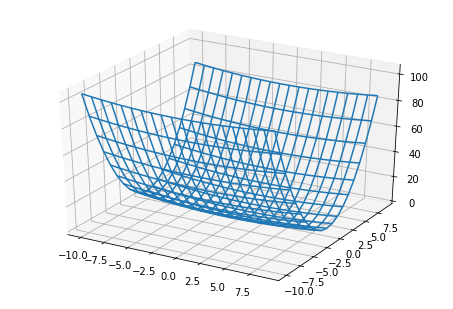

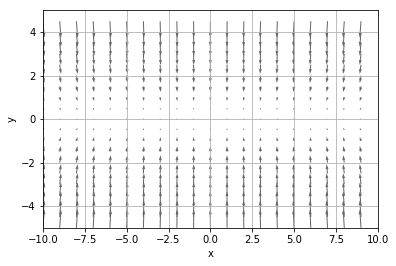

In [63]:
def function_1(x):
    return (x[0]**2)/20 + x[1]**2

# function_1 をグラフに描画する
x = [np.arange(-10, 10, 1), np.arange(-10, 10, 1)]
X, Y = np.meshgrid(x[0], x[1])
Z = function_1([X, Y])

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X,Y,Z)

plt.show()

# 勾配をグラフに図示
x0 = np.arange(-10, 10, 1)
x1 = np.arange(-5, 5, 0.5)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_1, np.array([X, Y]))
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")

plt.xlim([-10, 10])
plt.ylim([-5, 5])
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.draw()
plt.show()

グラフから分かること
* y軸方向は勾配が大きく，x軸方向は小さい（緩やか）
* 最小値は(0,0)だが，多くの点における勾配がこの方向を向いていない
  * **探索が非効率になる本質的な要因**

In [73]:
# 関数のSGDによる最適化過程を示すコードをここに追加する
# 初期値は (x,y)=(-7.0, 2.0)から開始する

### 6.1.4 Momentum
* 以下のように定式化される
  * ${\bf W}$：更新対象の重みパラメータ
  * $\frac{\partial L}{\partial {\bf W}}$：${\bf W}$に関する損失関数の勾配
  * $\eta$：学習係数
$${\bf v}\leftarrow \alpha{\bf v}-\eta\frac{\partial L}{\partial {\bf W}}$$
$${\bf W}\leftarrow {\bf W}+{\bf v}$$
* Momentumとは「運動量」という意味
* 新たに${\bf v}$という変数が導入される．物理でいうところの「速度」に相当する．
* 物体が勾配方向に力を受け，その力によって物体の速度が加算されるという物理法則を表す
* $\alpha {\bf v}$という項は物体が何も力を受けないときに徐々に減速するための役割を担う．摩擦抵抗や空気抵抗のようなもの．

In [5]:
class Momentum:
    # v は物体の速度を保持するインスタンス変数（初期化時には何も保持しない）
    def __init__(self, lr=0.01, moment=0.9):
        self.lr = lr
        self.moment = moment
        self.v = None
    
    def update(self, params, grads):
        # 初回呼び出し時，vはパラメータと同じ構造のデータをディクショナリ変数として保持する
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.moment*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]


In [ ]:
# Momentum を使って最適化問題を解いてみる


### 6.1.5 AdaGrad
* ニューラルネットの学習では学習係数の値が重要になる．
* 学習係数に関するテクニックとして学習係数の減衰(learning rate decay)という方法があり，AdaGradはさらにそれを発展させたもの
  * 学習が進むにつれて学習係数を小さくするということ
  * AdaGradでは，パラメータ一つ一つに対して適応的に学習係数を調整しながら学習を行う
* AdaGradは以下のように定式化される
  * ${\bf W}$：重みパラメータ
  * $\frac{\partial L}{\partial {\bf W}}$：${\bf W}$に関する損失関数の勾配
  * $\eta$：学習係数
  * ${\bf h}$：これまでに経験した勾配値の2乗和($\odot$は行列の要素ごとの掛け算を表す)
    * パラメータ更新の際，$\frac{1}{\sqrt{{\bf h}}}$を乗算することで学習のスケールを調整する
    * 大きく動いた変数ほど学習係数が小さくなる
    * 過去のすべての勾配の2乗和が加算されるため，更新量はどんどん0に近く（全く動かなくなる）
    * RMSPropという方法では，「指数移動平均」により指数関数的に過去の勾配のスケールを減少させることでこの問題を解決している
$${\bf h}\leftarrow{\bf h}+\frac{\partial L}{\partial {\bf W}}\odot \frac{\partial L}{\partial {\bf W}}　\\
{\bf W}\leftarrow{\bf W}-\eta\frac{1}{\sqrt{{\bf h}}}\frac{\partial L}{\partial {\bf W}}$$

In [6]:
# AdaGradの実装
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            # 1e-7という小さい値を加算することでself.h[key]の中に0があった場合のゼロ割を回避する
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### 6.1.6 Adam
* Momentum と Adam との融合をベースとした手法
* ハイパーパラメータのバイアス補正が行われるという特徴がある
* (参考)[論文「ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION」](https://arxiv.org/pdf/1412.6980.pdf)

In [7]:
# Adam の実装（common/optimizer.pyより）
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


### 6.1.7 どの更新手法を用いるか？

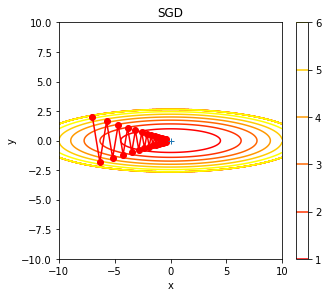

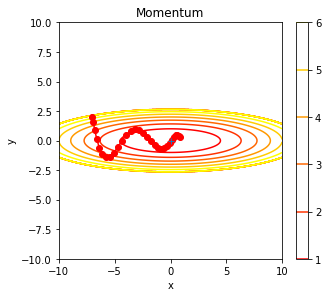

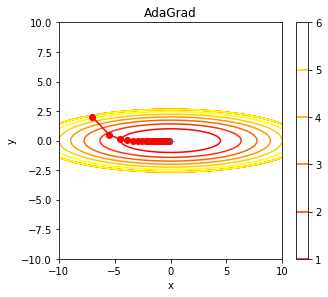

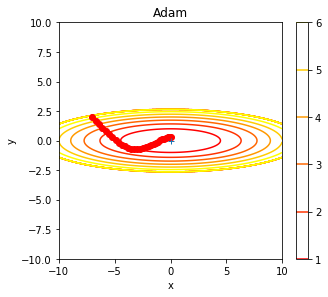

In [22]:
from collections import OrderedDict

# 2つのパラメータ x, y の関数f の最小値を求める

# 最適化対象の関数
def f(x, y):
    return x**2 / 20.0 + y**2

# 解析的に得られた対象関数の勾配
def df(x, y):
    return x / 10.0, 2.0*y

# 入力の初期値
init_pos = (-7.0, 2.0)
# パラメータ(ディクショナリ)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
# 勾配
grads = {}
grads['x'], grads['y'] = 0, 0

# 最適化手法いろいろ
optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

# それぞれの最適化手法に対して処理を行う
for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    # 最適化手法を使ってパラメータを30回更新する
    for i in range(30):
        # xおよびyの値を記録しておく
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        # 勾配を計算する．ここでは解析的に勾配が得られるためそれを使う
        grads['x'], grads['y'] = df(params['x'], params['y'])
        # パラメータの更新
        optimizer.update(params, grads)
    
    # パラメータの軌跡をプロット
    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    # 2つの配列x,yの各要素間の全ての組み合わせを得る
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot
    # 個々のグラフの表示サイズを調整
    plt.figure(figsize=(5,20))
    plt.subplot(4, 1, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    # 右側にz軸の色の説明用グラフが表示される
    plt.colorbar()
    # spring, summer, autumn, winter などで使用する色が変わる
    plt.autumn()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

### 6.1.8 MNISTデータセットによる更新手法の比較
* 手書き文字認識を対象に，これまでの4つの手法を比較し，学習の進み具合の違いを確認する
* 分かること：
  * SGDよりもそれ以外の手法が速く学習できている
  * SGD以外の手法ではAdaGradが少しだけ速いが，ハイパーパラメータやニューラルネットワークの構造により結果は変わり得る

===========iteration:0===========
SGD:2.42457001013
Momentum:2.3393273941
AdaGrad:2.12894860481
Adam:2.25437054053
===========iteration:100===========
SGD:1.62445116352
Momentum:0.370289413487
AdaGrad:0.140181242194
Adam:0.26620111258
===========iteration:200===========
SGD:0.839389487406
Momentum:0.456399092901
AdaGrad:0.214456392512
Adam:0.36890413192
===========iteration:300===========
SGD:0.525695005631
Momentum:0.288617458469
AdaGrad:0.0927778628365
Adam:0.1953362777
===========iteration:400===========
SGD:0.564521981899
Momentum:0.22431020157
AdaGrad:0.103656625588
Adam:0.164248301861
===========iteration:500===========
SGD:0.434890411937
Momentum:0.212999300457
AdaGrad:0.0809178991412
Adam:0.0924139415461
===========iteration:600===========
SGD:0.450036914301
Momentum:0.190517215595
AdaGrad:0.0857191925317
Adam:0.127495606344
===========iteration:700===========
SGD:0.345443179651
Momentum:0.132457558568
AdaGrad:0.0547421823954
Adam:0.11079588818
===========iteration:800=========

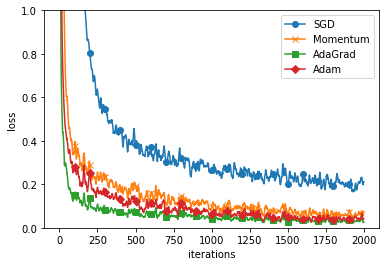

In [23]:
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet

# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 1:実験の設定==========
# 最適化手法
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:訓練の開始==========
for i in range(max_iterations):
    # ミニバッチ学習のデータを選ぶ
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # それぞれの最適化手法ごとに行う
    for key in optimizers.keys():
        # バッチを使って勾配を取得する
        grads = networks[key].gradient(x_batch, t_batch)
        # 勾配を元にパラメータを更新する
        optimizers[key].update(networks[key].params, grads)
        # 更新後の損失関数の値を計算する
        loss = networks[key].loss(x_batch, t_batch)
        # 損失関数の値を記録する
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()



## 6.2 重みの初期値
* 学習では重みパラメータの初期値は重要
  * 値により，成否が分かれることもある
* 推奨される初期値とは？

### 6.2.1 重みの初期値を0にする？
#### Weight decay
* 重みパラメータの値が小さくなるように学習を行うための手法．過学習が起きにくくなる．
* 重みの初期値をすべて0にするのは悪い方法．正しい学習が行えない
  * 正確には，重みを均一な値に設定してはいけない
  * (理由)誤差逆伝播法において，すべての重みの値が同じように更新されてしまい，重みを持つ意味がなくなる
  * そのため，過去のサンプルではランダムな初期値を与えていた

### 6.2.2 隠れ層のアクティベーション分布
* 隠れ層のアクティベーション（活性化関数を通した後の出力）の分布を観察してみる
  * ここでは，重みの初期値により隠れ層のアクティベーションがどのように変化するかを見てみる

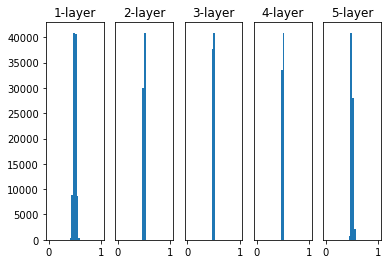

In [48]:
# 5層のニューラルネットワークにランダムな入力を流し，各層のアクティベーションのデータ分布をヒストグラムで描画する
# 活性化関数としてシグモイド関数，ReLU関数，双曲線関数(tanh)を使用する

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここに各層のアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    # 重みの初期値の値をいろいろ変えて実験しよう！
    ## 標準偏差が1の標準偏差
    #w = np.random.randn(node_num, node_num) * 1
    ## 標準偏差が0.01の標準偏差
    w = np.random.randn(node_num, node_num) * 0.01
    ## Xavierの初期値($\sqrt{\frac{1}{n}}$を標準偏差とするガウス分布)
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    ## Heの初期値($\sqrt{\frac{2}{n}}$を標準偏差とするガウス分布)
    #w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
    
    a = np.dot(x, w)
    
    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    #z = ReLU(a)
    #z = tanh(a)
    
    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()



#### 出力の考察
* 1を標準偏差とするガウス分布の場合
  * シグモイド関数の0と1における微分の値は共に0に近くことから，データ分布が0と1に偏っていると各層のアクティベーションは0と1に偏った分布になる．
  * 結果として，逆伝播での勾配値はどんどん小さくなる（**勾配消失(gradient vanishing)**という）
  * 層を深くするとさらに深刻になる
* 0.01を標準偏差とするガウス分布の場合
  * 中央(0.5)付近に集中する分布になる
  * 勾配の値が0にならないので勾配消失は生じない
  * 出力に差が出ていないため，ニューロンが複数存在する意味がなくなっている
* **効率的な学習のためには，各層のアクティベーションは適度に広がりをもつ分布であることが望ましい**

#### Xaviarの初期値

* [Xavier Glorotらの論文](http://proceedings.mlr.press/v9/glorot10a.html)で推奨される，重みの初期値
* 前層のノード個数を$n$とした場合に，$\sqrt{\frac{1}{n}}$を標準偏差とするガウス分布を用いる
* この初期値を用いると，広がりを持った分布になっていることが確認できる

### 6.2.3 ReLUの場合の重みの初期値
* 活性化関数がシグモイド関数の場合，Xavierの初期値を用いる($\sqrt{\frac{1}{n}}$を標準偏差とするガウス分布)
  * 本来，Xavierの初期値は活性化関数が線形関数であることを前提に導かれたものだが，中央付近が線形関数に近似できるとみなせるため使用している

#### Heの初期値
* 活性化関数がReLU関数の場合に用いられる重みの初期値
  * $\sqrt{\frac{2}{n}}$を標準偏差とするガウス分布
  * （直感的には）負の領域が0になるために係数に広がりを持たせる必要があると考えられる

### 6.2.4 MNISTデータセットによる重み初期値の比較

===========iteration:0===========
std=0.01:2.30247235257
Xavier:2.30123128342
He:2.39112844
===========iteration:100===========
std=0.01:2.30269588029
Xavier:2.2262128909
He:1.47229197647
===========iteration:200===========
std=0.01:2.30099707576
Xavier:2.09844149388
He:0.748945832167
===========iteration:300===========
std=0.01:2.30356621539
Xavier:1.85446774014
He:0.629758601156
===========iteration:400===========
std=0.01:2.30111983745
Xavier:1.36846513771
He:0.33002066809
===========iteration:500===========
std=0.01:2.30195618758
Xavier:0.947531996493
He:0.36181230802
===========iteration:600===========
std=0.01:2.30164815493
Xavier:0.645007415553
He:0.224861334764
===========iteration:700===========
std=0.01:2.30044650154
Xavier:0.659812657603
He:0.391263752847
===========iteration:800===========
std=0.01:2.30019986889
Xavier:0.435522699742
He:0.292596364621
===========iteration:900===========
std=0.01:2.30279785973
Xavier:0.435873394256
He:0.231563636375
===========iteration:1000

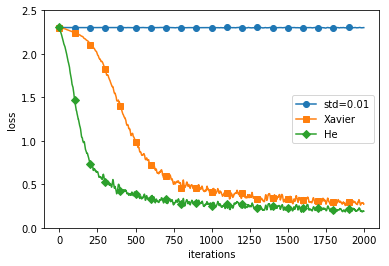

In [116]:
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
# それぞれの重みづけごとに，ネットワークを作り，動かしてみる
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

#### 出力のまとめ
* 0.01を標準偏差とするガウス分布は全く学習が進んでいない
* XavierおよびHeのいずれの場合も学習は進んでいる．Heの初期値の方が学習が速い．
* 重みの初期値の設定は学習の成否を分ける重要なポイントであることが確認できた

## 6.3 Batch Normalization
* 前節では，各層のアクティベーションの分布を観察し，適切な重みの初期値の設定によりアクティベーションの分布は適度な広がりを持ち，学習がスムーズに進むことを確認した
* [Batch Normalization](https://arxiv.org/abs/1502.03167) とは，各層で適度な広がりを持つように「強制的」にアクティベーションの分布を調整する手法

### 6.3.1 Batch Normalization のアルゴリズム
* Batch Normが注目されている理由
  * 学習を速く進行させることができる（学習係数を大きくできる）
  * 初期値にそれほど依存しない(初期値に神経質にならなくて良い）
  * 過学習を抑制する(Dropoutなどの必要性を減らす)

#### 手順
* AffineレイヤとReLUレイヤとの間にBatch Normレイヤを挿入する
* Batch Normでは，ミニバッチ単位で正規化処理を行う．具体的にはデータ分布が平均0，分散1になるようにする
  1. ミニバッチとして，$B=\{x_1, x_2,...,x_m\}$という$m$個の入力データの集合に対する平均$\mu_B$，分散$\sigma^2_B$を求める
  2. 入力データを平均が0で分散が1になるように正規化する
    * 下記の式で，$\epsilon$は小さい値(例えば 10e-7など)を示す（ゼロ割防止のため）
$$\mu_B\leftarrow \frac{1}{m}\sum^{m}_{i=1}x_i \\
\sigma^2_B\leftarrow \frac{1}{m}\sum^{m}_{i=1}(x_i-\mu_B)^2 \\
\hat{x_i}\leftarrow \frac{x_i-\mu_B}{\sqrt{\sigma^2_B+\epsilon}}$$
  3. 正規化されたデータに対し，固有のスケールとシフトで変換を行う
$$y_i\leftarrow \gamma \hat{x_i}+\beta$$
    * ここで$\gamma$と$\beta$はパラメータ．最初は$(\gamma,\beta)=(1,0)$からスタートし，学習により値が調整される．

#### Batch Normの逆伝播の導出（省略）

### 6.3.2 Batch Normalization の評価



============== 1/16 ==============
epoch:0 | 0.117 - 0.125


../deep_learning_from_scratch/common/functions.py:56: RuntimeWarning: divide by zero encountered in log
  batch_size = y.shape[0]
../deep_learning_from_scratch/common/layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)
../deep_learning_from_scratch/common/multi_layer_net_extend.py:101: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
../deep_learning_from_scratch/common/multi_layer_net_extend.py:101: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.139
epoch:2 | 0.097 - 0.15
epoch:3 | 0.097 - 0.144
epoch:4 | 0.097 - 0.161
epoch:5 | 0.097 - 0.176
epoch:6 | 0.097 - 0.204
epoch:7 | 0.097 - 0.211
epoch:8 | 0.097 - 0.232
epoch:9 | 0.097 - 0.249
epoch:10 | 0.097 - 0.27
epoch:11 | 0.097 - 0.287
epoch:12 | 0.097 - 0.301
epoch:13 | 0.097 - 0.304
epoch:14 | 0.097 - 0.32
epoch:15 | 0.097 - 0.327
epoch:16 | 0.097 - 0.333
epoch:17 | 0.097 - 0.359
epoch:18 | 0.097 - 0.378
epoch:19 | 0.097 - 0.392
============== 2/16 ==============
epoch:0 | 0.1 - 0.09


/Users/saito/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
../deep_learning_from_scratch/common/functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:1 | 0.097 - 0.098
epoch:2 | 0.097 - 0.13
epoch:3 | 0.097 - 0.144
epoch:4 | 0.097 - 0.171
epoch:5 | 0.097 - 0.199
epoch:6 | 0.097 - 0.228
epoch:7 | 0.097 - 0.262
epoch:8 | 0.097 - 0.28
epoch:9 | 0.097 - 0.301
epoch:10 | 0.097 - 0.329
epoch:11 | 0.097 - 0.348
epoch:12 | 0.097 - 0.364
epoch:13 | 0.097 - 0.375
epoch:14 | 0.097 - 0.38
epoch:15 | 0.097 - 0.401
epoch:16 | 0.097 - 0.407
epoch:17 | 0.097 - 0.426
epoch:18 | 0.097 - 0.446
epoch:19 | 0.097 - 0.462
============== 3/16 ==============
epoch:0 | 0.094 - 0.088
epoch:1 | 0.336 - 0.11
epoch:2 | 0.438 - 0.114
epoch:3 | 0.547 - 0.156
epoch:4 | 0.614 - 0.179
epoch:5 | 0.669 - 0.229
epoch:6 | 0.745 - 0.27
epoch:7 | 0.788 - 0.299
epoch:8 | 0.8 - 0.336
epoch:9 | 0.848 - 0.364
epoch:10 | 0.87 - 0.398
epoch:11 | 0.885 - 0.419
epoch:12 | 0.901 - 0.447
epoch:13 | 0.918 - 0.484
epoch:14 | 0.924 - 0.494
epoch:15 | 0.937 - 0.52
epoch:16 | 0.946 - 0.545
epoch:17 | 0.952 - 0.555
epoch:18 | 0.959 - 0.578
epoch:19 | 0.972 - 0.601
============== 4/1

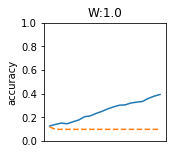

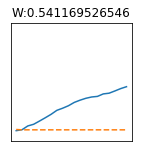

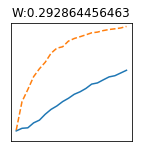

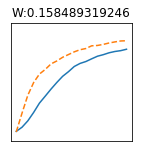

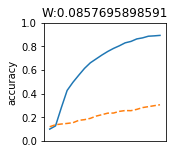

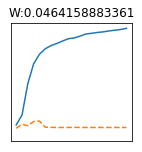

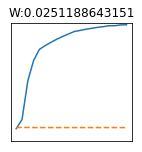

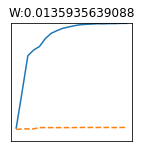

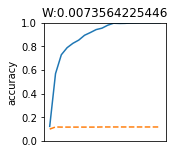

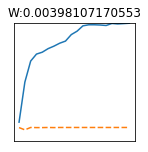

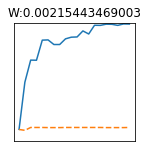

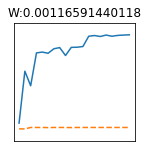

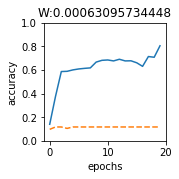

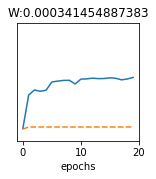

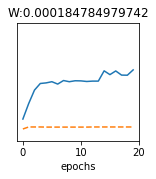

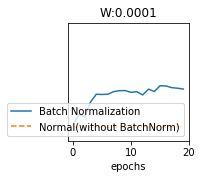

In [54]:
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 3.グラフの描画==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    # 個々のグラフの表示サイズを調整
    plt.figure(figsize=(10,10))
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

#### 結果の考察
* Batch Normにより，多くの場合で学習が速く進んでいる
* 重みの初期値の与え方により，Batch Normよりも速くなる場合があった
* Batch Normは初期値にそれほど依存しなくて済む（初期値にロバストになる）

## 6.4 正則化
* 機械学習では「過学習(overfitting)」が問題になる
  * 過学習とは，訓練データだけに適応しすぎて汎化性能が得られない状態
* 過学習を抑えるテクニックが必要になる

### 6.4.1 過学習
* 過学習が起きる原因
  * パラメータを大量に持ち，表現力の高いモデルである
  * 訓練データが少ない

epoch:0, train acc:0.11, test acc:0.0963
epoch:1, train acc:0.116666666667, test acc:0.1038
epoch:2, train acc:0.13, test acc:0.1164
epoch:3, train acc:0.156666666667, test acc:0.1261
epoch:4, train acc:0.176666666667, test acc:0.1354
epoch:5, train acc:0.183333333333, test acc:0.1455
epoch:6, train acc:0.193333333333, test acc:0.1579
epoch:7, train acc:0.21, test acc:0.1756
epoch:8, train acc:0.25, test acc:0.1996
epoch:9, train acc:0.296666666667, test acc:0.2204
epoch:10, train acc:0.306666666667, test acc:0.2417
epoch:11, train acc:0.316666666667, test acc:0.2525
epoch:12, train acc:0.346666666667, test acc:0.2666
epoch:13, train acc:0.376666666667, test acc:0.2904
epoch:14, train acc:0.41, test acc:0.3085
epoch:15, train acc:0.426666666667, test acc:0.3231
epoch:16, train acc:0.456666666667, test acc:0.3407
epoch:17, train acc:0.49, test acc:0.3749
epoch:18, train acc:0.513333333333, test acc:0.3879
epoch:19, train acc:0.536666666667, test acc:0.4138
epoch:20, train acc:0.60666666

epoch:173, train acc:1.0, test acc:0.7702
epoch:174, train acc:1.0, test acc:0.769
epoch:175, train acc:1.0, test acc:0.7697
epoch:176, train acc:1.0, test acc:0.7686
epoch:177, train acc:1.0, test acc:0.7695
epoch:178, train acc:1.0, test acc:0.7689
epoch:179, train acc:1.0, test acc:0.7694
epoch:180, train acc:1.0, test acc:0.7689
epoch:181, train acc:1.0, test acc:0.7699
epoch:182, train acc:1.0, test acc:0.7699
epoch:183, train acc:1.0, test acc:0.7692
epoch:184, train acc:1.0, test acc:0.7686
epoch:185, train acc:1.0, test acc:0.77
epoch:186, train acc:1.0, test acc:0.7696
epoch:187, train acc:1.0, test acc:0.7698
epoch:188, train acc:1.0, test acc:0.7687
epoch:189, train acc:1.0, test acc:0.7703
epoch:190, train acc:1.0, test acc:0.7707
epoch:191, train acc:1.0, test acc:0.7713
epoch:192, train acc:1.0, test acc:0.7708
epoch:193, train acc:1.0, test acc:0.7705
epoch:194, train acc:1.0, test acc:0.7706
epoch:195, train acc:1.0, test acc:0.771
epoch:196, train acc:1.0, test acc:0.7

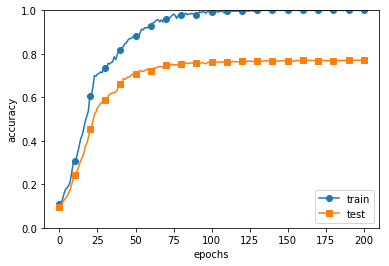

In [56]:
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
weight_decay_lambda = 0 # weight decayを使用しない場合
#weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#### 結果の考察
* 訓練データとテストデータとで，結果に大きな隔たりがある
  * 訓練データだけに適応してしまい，訓練時に使用しなかったデータへの対応がうまくできていない

### 6.4.2 Weight decay(荷重減衰)
* 過学習抑制のために用いられる方法
* 考え方：学習過程において，大きな重みを持つことに対し，ペナルティを課す
  * 過学習が大きな重みパラメータの値により発生することがよくある，という経験に基づく
* 方法：損失関数に重みの2乗ノルム（L2ノルム${\bf \frac{1}{2}\lambda W^2}$）を加算する
  * L2ノルムとは $\sqrt{w^2_1+w^2_2+\cdots++w^2_n}$ で計算できる．
  * $\lambda$は正則化の強さを制御するハイパーパラメータ，$\frac{1}{2}$倍するのは微分の結果を$\lambda{\bf W}$にするため
  * 学習過程は損失関数を最小にするように働くため，L2ノルムを足し込んだ値を最適化すれば重みの値が抑制されると期待できる

epoch:0, train acc:0.15, test acc:0.1135
epoch:1, train acc:0.17, test acc:0.1228
epoch:2, train acc:0.223333333333, test acc:0.1504
epoch:3, train acc:0.24, test acc:0.1666
epoch:4, train acc:0.27, test acc:0.1943
epoch:5, train acc:0.296666666667, test acc:0.2147
epoch:6, train acc:0.336666666667, test acc:0.2324
epoch:7, train acc:0.356666666667, test acc:0.246
epoch:8, train acc:0.373333333333, test acc:0.262
epoch:9, train acc:0.373333333333, test acc:0.2608
epoch:10, train acc:0.376666666667, test acc:0.2685
epoch:11, train acc:0.393333333333, test acc:0.2855
epoch:12, train acc:0.423333333333, test acc:0.3073
epoch:13, train acc:0.43, test acc:0.3159
epoch:14, train acc:0.446666666667, test acc:0.328
epoch:15, train acc:0.47, test acc:0.3472
epoch:16, train acc:0.506666666667, test acc:0.3686
epoch:17, train acc:0.5, test acc:0.3701
epoch:18, train acc:0.5, test acc:0.3734
epoch:19, train acc:0.523333333333, test acc:0.3892
epoch:20, train acc:0.55, test acc:0.4066
epoch:21, tra

epoch:169, train acc:0.89, test acc:0.7263
epoch:170, train acc:0.893333333333, test acc:0.7316
epoch:171, train acc:0.886666666667, test acc:0.7242
epoch:172, train acc:0.886666666667, test acc:0.7214
epoch:173, train acc:0.883333333333, test acc:0.7277
epoch:174, train acc:0.89, test acc:0.7275
epoch:175, train acc:0.883333333333, test acc:0.7229
epoch:176, train acc:0.886666666667, test acc:0.7197
epoch:177, train acc:0.886666666667, test acc:0.7201
epoch:178, train acc:0.89, test acc:0.7246
epoch:179, train acc:0.896666666667, test acc:0.7279
epoch:180, train acc:0.896666666667, test acc:0.7233
epoch:181, train acc:0.896666666667, test acc:0.7246
epoch:182, train acc:0.9, test acc:0.7264
epoch:183, train acc:0.883333333333, test acc:0.7206
epoch:184, train acc:0.896666666667, test acc:0.7285
epoch:185, train acc:0.903333333333, test acc:0.7304
epoch:186, train acc:0.896666666667, test acc:0.7259
epoch:187, train acc:0.893333333333, test acc:0.734
epoch:188, train acc:0.896666666667

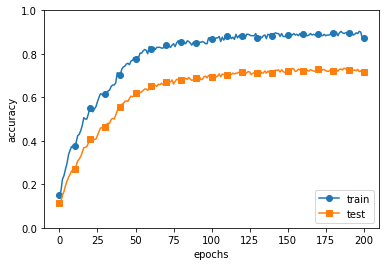

In [55]:
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
#weight_decay_lambda = 0 # weight decayを使用しない場合
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#### 結果の考察
* 訓練データとテストデータとの認識精度には隔たりがあるが，Weight decayを用いない場合に比べて隔たり具合は小さい
* 訓練データの認識精度が100％に達していない．訓練データの認識精度は落ちている
* 隔たりが少ないということは，訓練データの認識精度がテストデータに対する認識精度の参考になりうるということでもある

### 6.4.3 Dropout
* ニューロンをランダムに消去しながら学習する手法
  * ニューラルネットワークのモデルが複雑になると，Weight decayだけでは対応が困難になるため，使用される
* 訓練時に，データが流れるたびに，ニューロンをランダムに選択し，そのニューロンを消去する．
  * 消去されたニューロンは信号の伝達が行われなくなる
* テスト時には全てのニューロンの信号を伝達する．その際，各ニューロンの出力に対し，訓練時に消去した割合を乗算して出力する

train loss:2.3857331614
=== epoch:1, train acc:0.0833333333333, test acc:0.0989 ===
train loss:2.33322080588
train loss:2.2966696744
train loss:2.28977640405
=== epoch:2, train acc:0.0966666666667, test acc:0.1041 ===
train loss:2.34706452355
train loss:2.25644070709
train loss:2.25734234781
=== epoch:3, train acc:0.113333333333, test acc:0.111 ===
train loss:2.27863180707
train loss:2.2949198361
train loss:2.24988841339
=== epoch:4, train acc:0.143333333333, test acc:0.129 ===
train loss:2.24378039804
train loss:2.22899548128
train loss:2.2597445134
=== epoch:5, train acc:0.17, test acc:0.1428 ===
train loss:2.25278859234
train loss:2.2655158041
train loss:2.2340238386
=== epoch:6, train acc:0.196666666667, test acc:0.1544 ===
train loss:2.21032674561
train loss:2.17955834562
train loss:2.16471123826
=== epoch:7, train acc:0.213333333333, test acc:0.1634 ===
train loss:2.20605455151
train loss:2.17474775659
train loss:2.16004129527
=== epoch:8, train acc:0.22, test acc:0.1773 ===
trai

train loss:0.295747741259
=== epoch:63, train acc:0.933333333333, test acc:0.6877 ===
train loss:0.419144539827
train loss:0.375727251482
train loss:0.315591318148
=== epoch:64, train acc:0.933333333333, test acc:0.6831 ===
train loss:0.224316311406
train loss:0.336144105207
train loss:0.274806436129
=== epoch:65, train acc:0.94, test acc:0.6876 ===
train loss:0.34964953865
train loss:0.33558160529
train loss:0.229185895742
=== epoch:66, train acc:0.936666666667, test acc:0.6857 ===
train loss:0.274395864037
train loss:0.375303198118
train loss:0.190978036306
=== epoch:67, train acc:0.943333333333, test acc:0.6899 ===
train loss:0.306762443172
train loss:0.266067415925
train loss:0.254672896149
=== epoch:68, train acc:0.94, test acc:0.682 ===
train loss:0.300881419806
train loss:0.317315934288
train loss:0.35135275854
=== epoch:69, train acc:0.953333333333, test acc:0.6869 ===
train loss:0.390436438846
train loss:0.26781196101
train loss:0.305435549108
=== epoch:70, train acc:0.95, tes

train loss:0.103142841548
train loss:0.0642345193731
train loss:0.0791746844925
=== epoch:124, train acc:1.0, test acc:0.7231 ===
train loss:0.0735156104214
train loss:0.0627242907376
train loss:0.0497480915889
=== epoch:125, train acc:1.0, test acc:0.7222 ===
train loss:0.0580275893968
train loss:0.078835103968
train loss:0.062402324823
=== epoch:126, train acc:1.0, test acc:0.7234 ===
train loss:0.0699475138919
train loss:0.0563756932359
train loss:0.0503950111536
=== epoch:127, train acc:1.0, test acc:0.7233 ===
train loss:0.0564862719272
train loss:0.0517148620675
train loss:0.0467032441573
=== epoch:128, train acc:1.0, test acc:0.7243 ===
train loss:0.0441988022218
train loss:0.0547311474181
train loss:0.0638809403922
=== epoch:129, train acc:1.0, test acc:0.7251 ===
train loss:0.0590354362558
train loss:0.0496885972419
train loss:0.0603663630096
=== epoch:130, train acc:1.0, test acc:0.7237 ===
train loss:0.0521426843556
train loss:0.0542121159894
train loss:0.0467734266731
=== e

=== epoch:186, train acc:1.0, test acc:0.7331 ===
train loss:0.0205241838539
train loss:0.0168040469811
train loss:0.0260591677732
=== epoch:187, train acc:1.0, test acc:0.7328 ===
train loss:0.0216898427472
train loss:0.0192160355009
train loss:0.021763732859
=== epoch:188, train acc:1.0, test acc:0.733 ===
train loss:0.0301269024062
train loss:0.0267607039518
train loss:0.0253562009743
=== epoch:189, train acc:1.0, test acc:0.7323 ===
train loss:0.0315248453439
train loss:0.0186150604456
train loss:0.0207781305932
=== epoch:190, train acc:1.0, test acc:0.7331 ===
train loss:0.0209436369593
train loss:0.0218885623673
train loss:0.0170972366909
=== epoch:191, train acc:1.0, test acc:0.7343 ===
train loss:0.0175104085672
train loss:0.0192380494414
train loss:0.0211253012275
=== epoch:192, train acc:1.0, test acc:0.7347 ===
train loss:0.0244903439815
train loss:0.0166053598948
train loss:0.0161995090497
=== epoch:193, train acc:1.0, test acc:0.7349 ===
train loss:0.018108681695
train los

train loss:0.0115006617572
=== epoch:249, train acc:1.0, test acc:0.7356 ===
train loss:0.010349061737
train loss:0.012638970001
train loss:0.0130580378263
=== epoch:250, train acc:1.0, test acc:0.7358 ===
train loss:0.0129384593399
train loss:0.0127394349599
train loss:0.0122518103563
=== epoch:251, train acc:1.0, test acc:0.7365 ===
train loss:0.0122286603425
train loss:0.0148005791931
train loss:0.0100992416752
=== epoch:252, train acc:1.0, test acc:0.7362 ===
train loss:0.0160192222848
train loss:0.01284128978
train loss:0.0148214216451
=== epoch:253, train acc:1.0, test acc:0.7371 ===
train loss:0.0115607175905
train loss:0.0103128569334
train loss:0.012975878908
=== epoch:254, train acc:1.0, test acc:0.736 ===
train loss:0.0110656761755
train loss:0.014288921853
train loss:0.0115231350632
=== epoch:255, train acc:1.0, test acc:0.7364 ===
train loss:0.0121725746176
train loss:0.00971331801896
train loss:0.0129566707141
=== epoch:256, train acc:1.0, test acc:0.7356 ===
train loss:0

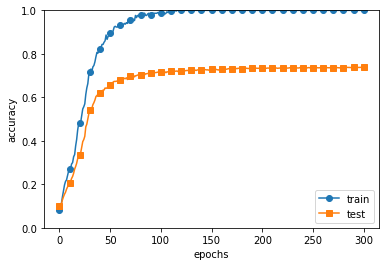

In [58]:
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuoutの有無、割り合いの設定 ========================
use_dropout = False  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

train loss:2.30079512321
=== epoch:1, train acc:0.1, test acc:0.1001 ===
train loss:2.30484640951
train loss:2.28647305254
train loss:2.28871230913
=== epoch:2, train acc:0.116666666667, test acc:0.0996 ===
train loss:2.28919120609
train loss:2.31223231019
train loss:2.30513271874
=== epoch:3, train acc:0.126666666667, test acc:0.1065 ===
train loss:2.30636910849
train loss:2.32598203327
train loss:2.27754745882
=== epoch:4, train acc:0.126666666667, test acc:0.1064 ===
train loss:2.29081510702
train loss:2.27841232553
train loss:2.27900705072
=== epoch:5, train acc:0.116666666667, test acc:0.1094 ===
train loss:2.29517524679
train loss:2.27364931703
train loss:2.28161459712
=== epoch:6, train acc:0.126666666667, test acc:0.1106 ===
train loss:2.29364678576
train loss:2.30517244978
train loss:2.25728179675
=== epoch:7, train acc:0.12, test acc:0.1133 ===
train loss:2.29533851936
train loss:2.30053779693
train loss:2.2742905265
=== epoch:8, train acc:0.123333333333, test acc:0.113 ===
t

=== epoch:64, train acc:0.183333333333, test acc:0.1542 ===
train loss:2.10770034498
train loss:2.18877713447
train loss:2.15735685475
=== epoch:65, train acc:0.18, test acc:0.153 ===
train loss:2.18414416351
train loss:2.15822415868
train loss:2.23745784717
=== epoch:66, train acc:0.186666666667, test acc:0.154 ===
train loss:2.12672830485
train loss:2.18342794524
train loss:2.19291067063
=== epoch:67, train acc:0.186666666667, test acc:0.1541 ===
train loss:2.19603611097
train loss:2.16778298509
train loss:2.17704339084
=== epoch:68, train acc:0.186666666667, test acc:0.1558 ===
train loss:2.18383810894
train loss:2.16073816505
train loss:2.17609224207
=== epoch:69, train acc:0.19, test acc:0.1575 ===
train loss:2.17815470181
train loss:2.18676021214
train loss:2.17026766142
=== epoch:70, train acc:0.193333333333, test acc:0.1589 ===
train loss:2.17627036915
train loss:2.18472008907
train loss:2.12598379067
=== epoch:71, train acc:0.196666666667, test acc:0.1597 ===
train loss:2.1436

=== epoch:126, train acc:0.413333333333, test acc:0.3345 ===
train loss:1.99872659975
train loss:1.99898991757
train loss:1.81470922795
=== epoch:127, train acc:0.413333333333, test acc:0.3368 ===
train loss:1.94994065843
train loss:1.99484204291
train loss:1.93792000568
=== epoch:128, train acc:0.413333333333, test acc:0.3384 ===
train loss:1.9982057759
train loss:1.94682357701
train loss:1.93376832887
=== epoch:129, train acc:0.413333333333, test acc:0.3382 ===
train loss:1.98081543302
train loss:1.96651777515
train loss:1.96029283657
=== epoch:130, train acc:0.426666666667, test acc:0.3451 ===
train loss:2.03104049381
train loss:1.92609927281
train loss:1.93371497554
=== epoch:131, train acc:0.44, test acc:0.3527 ===
train loss:1.92272428713
train loss:2.03432146163
train loss:1.98961980494
=== epoch:132, train acc:0.446666666667, test acc:0.3599 ===
train loss:1.90572568504
train loss:1.95465364171
train loss:2.00463425928
=== epoch:133, train acc:0.443333333333, test acc:0.3624 ==

=== epoch:188, train acc:0.536666666667, test acc:0.4375 ===
train loss:1.71049545865
train loss:1.64378603485
train loss:1.66964627908
=== epoch:189, train acc:0.526666666667, test acc:0.4366 ===
train loss:1.69482984244
train loss:1.6454224999
train loss:1.61975406567
=== epoch:190, train acc:0.533333333333, test acc:0.4358 ===
train loss:1.7108557807
train loss:1.69724401476
train loss:1.64830019342
=== epoch:191, train acc:0.53, test acc:0.4373 ===
train loss:1.56671769411
train loss:1.64912079361
train loss:1.7438187545
=== epoch:192, train acc:0.55, test acc:0.4406 ===
train loss:1.69117392097
train loss:1.62511251077
train loss:1.54908244951
=== epoch:193, train acc:0.543333333333, test acc:0.4385 ===
train loss:1.59252395358
train loss:1.50202177967
train loss:1.55622181578
=== epoch:194, train acc:0.53, test acc:0.4357 ===
train loss:1.59214579628
train loss:1.58841442397
train loss:1.53213081594
=== epoch:195, train acc:0.536666666667, test acc:0.4372 ===
train loss:1.7078332

=== epoch:250, train acc:0.606666666667, test acc:0.4761 ===
train loss:1.30620955645
train loss:1.42976886505
train loss:1.51140972309
=== epoch:251, train acc:0.596666666667, test acc:0.4797 ===
train loss:1.22843594669
train loss:1.30135055465
train loss:1.34188297515
=== epoch:252, train acc:0.596666666667, test acc:0.4813 ===
train loss:1.31720373339
train loss:1.33403481447
train loss:1.3454757292
=== epoch:253, train acc:0.6, test acc:0.4816 ===
train loss:1.34056114776
train loss:1.33787215822
train loss:1.43133617246
=== epoch:254, train acc:0.606666666667, test acc:0.4791 ===
train loss:1.42145220188
train loss:1.16625961345
train loss:1.31745233883
=== epoch:255, train acc:0.603333333333, test acc:0.4775 ===
train loss:1.30972419731
train loss:1.43026680266
train loss:1.13800648267
=== epoch:256, train acc:0.596666666667, test acc:0.4781 ===
train loss:1.24573498746
train loss:1.29838573873
train loss:1.41252255857
=== epoch:257, train acc:0.613333333333, test acc:0.4741 ===

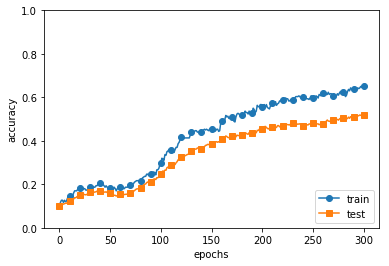

In [57]:
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuoutの有無、割り合いの設定 ========================
use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#### 結果の考察
* Dropoutを用いることで訓練データとテストデータとの認識精度の隔たりが小さくなった
* 訓練データが100%の認識精度に到達することもなくなった
* 実装では Dropout は一つのレイヤとして実装し，通さない場合に0を出力するように実装する．
  * Dropoutレイヤクラスの定義は common/layers.py にある
  * forward処理では，train_flg をパラメタとして受け取る．これは訓練中か推論中かを示すもの
  * 訓練中の場合は，0から1の間のランダム値を生成し，dropout_ratio の値より小さい場合は出力を0にする
  * 逆伝播では出力0（切り落とされた場合）の場合も0になるようにする
  * 推論処理では，dropout_ratio の割合を1から減じた値(つまり，通過した割合)を出力に掛け合わせる

## 6.5 ハイパーパラメータの検証
* ハイパーパラメータは適切な値に設定しなければ性能の悪いモデルになってしまうため，重要である
* ハイパーパラメータの決定には一般に多くの試行錯誤が必要となる
* ここではなるべく効率的にハイパーパラメータの値を探索する方法について扱う

### 6.5.1 検証データ
* テストデータを使ってハイパーパラメータの性能を評価してはダメ
  * テストデータを使って調整するとハイパーパラメータの値がテストデータの値に過学習を起こしてしまうため
* ハイパーパラメータを調整する際にはそれ専用の確認データが必要．このデータのことを一般に検証データ（validation data）という
* 使用するデータセットによっては訓練データ・検証データ・テストデータに分離してあるものもある
* 分離されていないデータセットの場合は各自で行う必要がある
* MNISTの場合，訓練データから20%程度を検証データとしてあらかじめ分離しておく．

In [63]:
# 検証データを訓練データから分離する
from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist()

# 訓練データをシャッフル
x_train, t_train = shuffle_dataset(x_train, t_train)

# 検証データの分離
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = x_train[:validation_num]

x_train = x_train[validation_num:]
t_train = x_train[validation_num:]

### 6.5.2 ハイパーパラメータの最適化
* ポイント：ハイパーパラメータの「良い値」が存在する範囲を徐々に絞り込むこと
  * 最初は大まかに範囲を設定し，その範囲の中からランダムにハイパーパラメータを選び出し，その値で認識精度の評価を行う
  * これを数回繰り返し，認識精度の結果を観察し，その結果から良い値の範囲を狭めてゆく
* ハイパーパラメータの最適化においては順番に規則正しく探索するよりもランダムにサンプリングして探索する方が良い結果になる，という報告がある
* ハイパーパラメータの範囲は，おおまかにざっくりと指定（たとえば対数スケールで指定）するのが有効
* パラメータの最適化で注意すべき点は，深層学習の学習には多くの時間が必要になる
  * 筋の悪そうなパラメータは早い段階で見切りをつけることが大事
* エポックを小さくして1回の評価に要する時間を短縮するのが有効

#### 手順
1. ハイパーパラメータの範囲を設定する
2. 設定されたハイパーパラメータの範囲から，ランダムにサンプリングする
3. ステップ2でサンプリングされたハイパーパラメータの値を使用して学習を行い，検証データで認識精度を評価（ただし，エポックは小さく設定）
4. ステップ2と3をある回数（100回くらい）繰り返し，それらの認識精度の結果から，ハイパーパラメータの値を狭める
5. ある程度絞り込んだ段階で，その範囲から一つ選び出す

#### より洗練された手法を求めるならば
* ベイズ最適化(Bayesian optimization)を検討する
* [論文](https://arxiv.org/pdf/1206.2944.pdf)を参照

### 6.5.3 ハイパーパラメータ最適化の実装
* ここでは学習係数とWeight decayの強さを制御する係数を探索してみる

val acc:0.18 | lr:0.0005060657923876856, weight decay:1.6058723085253106e-06
val acc:0.15 | lr:0.00014483614341682442, weight decay:3.237158319950058e-05
val acc:0.08 | lr:5.4627449964543656e-05, weight decay:2.3101014888075248e-08
val acc:0.14 | lr:4.5108601922114896e-05, weight decay:1.1430358745821778e-05
val acc:0.14 | lr:7.873501769710435e-05, weight decay:2.605143216485031e-05
val acc:0.16 | lr:1.0536714318315737e-06, weight decay:6.025191950163513e-08
val acc:0.08 | lr:1.3554484269139541e-06, weight decay:1.0762017749315694e-07
val acc:0.5 | lr:0.002650757965805373, weight decay:3.221914617142062e-05
val acc:0.74 | lr:0.008352017201145763, weight decay:3.054859859616235e-05
val acc:0.12 | lr:9.173345880790738e-06, weight decay:3.894363822638439e-05
val acc:0.12 | lr:3.983336782348144e-06, weight decay:1.979379454637882e-05
val acc:0.09 | lr:0.00026895473585591446, weight decay:1.9183542396687543e-07
val acc:0.1 | lr:0.0004134768363202313, weight decay:1.0213409869983522e-08
val 

Best-7(val acc:0.52) | lr:0.00427179655723402, weight decay:1.238986517976998e-06
Best-8(val acc:0.51) | lr:0.004075886404513769, weight decay:6.603953102048141e-06
Best-9(val acc:0.51) | lr:0.004437988467631253, weight decay:7.468522285592859e-06
Best-10(val acc:0.5) | lr:0.002650757965805373, weight decay:3.221914617142062e-05
Best-11(val acc:0.46) | lr:0.004188838969861383, weight decay:3.403396154358986e-07
Best-12(val acc:0.44) | lr:0.0021876745734083045, weight decay:3.201786579451656e-05
Best-13(val acc:0.44) | lr:0.0033384401359858986, weight decay:1.3930172218643598e-07
Best-14(val acc:0.4) | lr:0.00289383866747621, weight decay:7.005677444822243e-08
Best-15(val acc:0.35) | lr:0.0033963205014678273, weight decay:6.0530024998001836e-05
Best-16(val acc:0.28) | lr:0.0010541169743226116, weight decay:2.327979373949247e-07
Best-17(val acc:0.27) | lr:0.0009276552205639737, weight decay:7.394282332541263e-05
Best-18(val acc:0.23) | lr:0.0014340385427299258, weight decay:3.27252777484

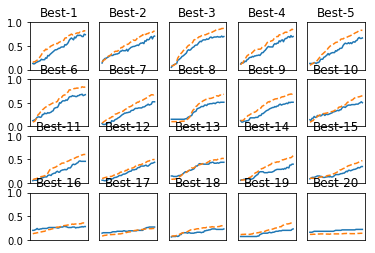

In [68]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = x_train.shape[0] * validation_rate
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:int(validation_num)]
t_val = t_train[:int(validation_num)]
x_train = x_train[int(validation_num):]
t_train = t_train[int(validation_num):]

def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索したハイパーパラメータの範囲を指定===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

## 6.6 まとめ
* やったこと：ニューラルネットワークの学習を行う上で重要ないくつかのテクニック
  * パラメータの更新方法
    * Momentum
    * AdaGrad
    * Adam
  * 重みの初期値の与え方：正しい学習を行う上で非常に重要
    * Xavierの初期値
    * Heの初期値
  * Batch Normalization：学習を速く進め，初期値に対してロバストになる
  * 過学習を抑制するための正則化
    * Weight decay
    * Dropout
  * ハイパーパラメータの探索：良い値が存在する範囲を徐々に絞りながら進めるのが効率良い